In [34]:
import timeit
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
sys.path.append('../models/')
import sentiment as sentimentinterface
import classify as classify
from wordcloud import WordCloud,STOPWORDS

In [35]:
import lime
import sklearn

In [36]:
import nltk
#nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [37]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset = 'train')
newsgroups_test = fetch_20newsgroups(subset = 'test')

In [38]:
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [39]:
categories = ['alt.atheism', 'comp.sys.mac.hardware', 'rec.autos', 'sci.med', 'talk.politics.mideast']

In [40]:
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

In [41]:
newsgroups_train.filenames.shape, newsgroups_test.filenames.shape

((2810,), (1872,))

In [42]:
newsgroups_train.data[:10]

['From: aas7@po.CWRU.Edu (Andrew A. Spencer)\nSubject: Re: MR2 - noisy engine.\nOrganization: Case Western Reserve University, Cleveland, OH (USA)\nLines: 33\nReply-To: aas7@po.CWRU.Edu (Andrew A. Spencer)\nNNTP-Posting-Host: slc5.ins.cwru.edu\n\n\nIn a previous article, eliot@lanmola.engr.washington.edu (eliot) says:\n\n>In article <1r1vofINN871@usenet.pa.dec.com> tomacj@opco.enet.dec.com (THUNDERBIRDS ARE GO !!!) writes:\n>>\tAre there any MR2 owners or motor-head gurus out there, that know why\n>>my MR2\'s engine sounds noisy? The MR2\'s engine is noisy at the best of times, \n>>but not even a nice nose - it\'s one of those very ugly noises. \n>\n>assuming yours is a non turbo MR2, the gruffness is characteristic of\n>a large inline 4 that doesn\'t have balance shafts.  i guess toyota\n>didn\'t care about "little" details like that when they can brag about\n>the mid engine configuration and the flashy styling.\n>\n>myself, i automatically cross out any car from consideration (or\n>r

In [43]:
newsgroups_train.target[:10]

array([2, 1, 0, 4, 2, 1, 3, 0, 2, 0])

In [44]:
newsgroups_train.target_names[:10]

['alt.atheism',
 'comp.sys.mac.hardware',
 'rec.autos',
 'sci.med',
 'talk.politics.mideast']

In [45]:
print('TfidfVectorizer:')
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train.count_vect = TfidfVectorizer(max_features = 200000, min_df = 1, max_df = 1.0, tokenizer = LemmaTokenizer(), sublinear_tf = False, ngram_range = (1, 3), stop_words = frozenset(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']))
trainX = newsgroups_train.count_vect.fit_transform(newsgroups_train.data)
devX = newsgroups_train.count_vect.transform(newsgroups_test.data)

TfidfVectorizer:


In [46]:
print("\nTraining classifier")
cval = 8
clf = classify.train_classifier(trainX, newsgroups_train.target, cval, 'l2','lbfgs')
print('Training input shape: ' + str(trainX.shape))
print("\nEvaluating")
train_acc, train_prob, train_pred = classify.evaluate(trainX, newsgroups_train.target, clf, name = 'training data')
dev_acc, dev_prob, dev_pred = classify.evaluate(devX, newsgroups_test.target, clf, name = 'validation data')
print('Train accuracy: ' + str(train_acc))
print('Dev accuracy: ' + str(dev_acc))


Training classifier


/Users/divyank/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training input shape: (2810, 200000)

Evaluating
Train accuracy: 0.998220640569395
Dev accuracy: 0.9123931623931624


## 1.1 How confident our model is in prediction?

In [47]:
def find_correct_incorrect(pred_prob, pred_lb, gt_lb, conf_score=0.8):
    """
    Use given confidence score as threshold for treating a given prediction confident.
    Then, returns the percentage of confident samples pedicted correctly and incorrectly.
    """
    confident_pred = []
    nconfident_pred = []
    for idx in range(len(pred_prob)):
        if max(pred_prob[idx]) >= conf_score:
            confident_pred.append(idx)
        else:
            nconfident_pred.append(idx)

    # classifier is confident about predictions on this much percentage
    confident_perc = round(100*len(confident_pred)/len(pred_prob), 2)
    nconfident_perc = 100. - confident_perc
    print("Classifier is confident about {}% of predictions".format(confident_perc))
    
    # classifier is correct/incorrect on confident predictions
    confident_corr = 0
    confident_incorr = 0
    for idx in confident_pred:
        if(gt_lb[idx] == pred_lb[idx]):
            confident_corr += 1
        else:
            confident_incorr += 1

    
    correct_perc = round(100*confident_corr/len(confident_pred), 2)
    incorrect_perc = round(100*confident_incorr/len(confident_pred), 2)
    print("Classifier is correct {}% times on confident predictions".format(correct_perc))
    print("Classifier is incorrect {}% times on confident predictions".format(incorrect_perc))
    
    # classifier is correct/incorrect on not-confident predictions
    print("Classifier is not confident about {}% of predictions".format(nconfident_perc))
    nconfident_corr = 0
    nconfident_incorr = 0
    for idx in nconfident_pred:
        if(gt_lb[idx] == pred_lb[idx]):
            nconfident_corr += 1
        else:
            nconfident_incorr += 1
    
    ncorrect_perc = round(100*nconfident_corr/len(nconfident_pred), 2)
    nincorrect_perc = round(100*nconfident_incorr/len(nconfident_pred), 2)
    print("Classifier is correct {}% times on non-confident predictions".format(ncorrect_perc))
    print("Classifier is incorrect {}% times on non-confident predictions".format(nincorrect_perc))
    
    return confident_perc, correct_perc, incorrect_perc, nconfident_perc, ncorrect_perc, nincorrect_perc
    

In [48]:
CONF_TH=0.8
conf_pred, conf_predc, conf_predinc, nconf_pred, nconf_predc, nconf_predinc = \
        find_correct_incorrect(dev_prob, dev_pred, newsgroups_test.target, CONF_TH)

Classifier is confident about 41.99% of predictions
Classifier is correct 99.87% times on confident predictions
Classifier is incorrect 0.13% times on confident predictions
Classifier is not confident about 58.01% of predictions
Classifier is correct 84.99% times on non-confident predictions
Classifier is incorrect 15.01% times on non-confident predictions


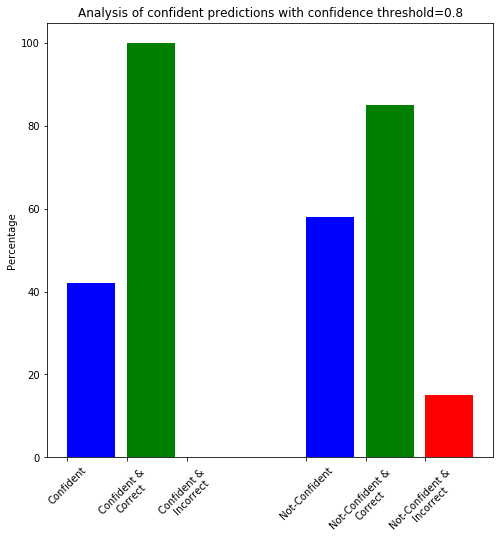

In [49]:
x_conf = [0, 1, 2]
x_nconf = [4, 5, 6]
scores_conf = [conf_pred, conf_predc, conf_predinc]
scores_nconf = [nconf_pred, nconf_predc, nconf_predinc]

plt.figure(1,figsize=(8, 8))
plt.bar(x_conf+x_nconf, scores_conf+scores_nconf, color = ('b', 'g', 'r', 'b', 'g', 'r'), align='edge')

#plt.bar(x_nconf, scores_nconf, color = ('b', 'g', 'r'), align='edge')
# Text on the top of each barplot
#for i in range(len(x_)):
#    plt.text(x = x_[i] , y = x_[i], s = scores_[i], size = 15, color='white')

plt.xticks(x_conf + x_nconf, 
          ('Confident', 'Confident & \nCorrect', 'Confident & \n Incorrect',
           'Not-Confident', 'Not-Confident & \nCorrect', 'Not-Confident & \n Incorrect'), rotation=45)

plt.ylabel('Percentage')
plt.title('Analysis of confident predictions with confidence threshold='+str(CONF_TH))
plt.savefig('../graph/confidence.png', format='png', dpi=100)
plt.savefig('../app/static/confidence.png', format='png', dpi=100)

## 1.2 Top K Positive and Negative words in input that affect prediction?

In [50]:
def plot_topk_wordcloud(clf, feat_names, k, clas):
    coefficients=clf.coef_[classes.index(clas)]
    top_k=np.argsort(coefficients)[-k:]

    top_k_words = []
    for i in top_k:
        #print(feat_names[i], coefficients[i])
        top_k_words.append(feat_names[i])
    
    words = " ".join(top_k_words)
    # TODO: if required to scale frequency of words as per weights
    # plot wordcloud
    wordcloud = WordCloud(
            stopwords=STOPWORDS, background_color='white', width=500, height=500).generate(words)
    plt.figure(1,figsize=(5, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Top '+ str(k) + ' ' + clas + ' words', size=15)
    plt.savefig('../graph/' + clas + '.png', format='png', dpi=200)
    plt.savefig('../app/static/' + clas + '.png', format='png', dpi=200)

In [51]:
clf.coef_.shape

(5, 200000)

In [52]:
classes = ['alt.atheism', 'comp.sys.mac.hardware', 'rec.autos', 'sci.med', 'talk.politics.mideast']

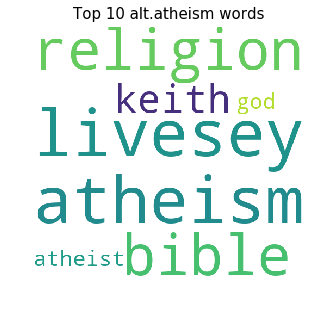

In [53]:
feat_names = newsgroups_train.count_vect.get_feature_names()
plot_topk_wordcloud(clf, feat_names, 10, categories[0])

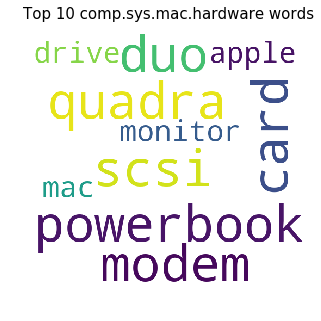

In [54]:
feat_names = newsgroups_train.count_vect.get_feature_names()
plot_topk_wordcloud(clf, feat_names, 10, categories[1])

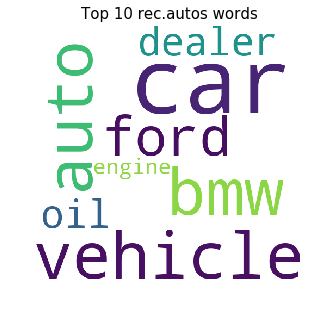

In [55]:
feat_names = newsgroups_train.count_vect.get_feature_names()
plot_topk_wordcloud(clf, feat_names, 10, categories[2])

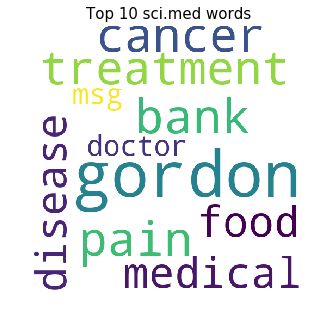

In [56]:
feat_names = newsgroups_train.count_vect.get_feature_names()
plot_topk_wordcloud(clf, feat_names, 10, categories[3])

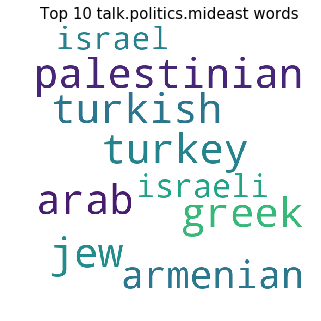

In [57]:
feat_names = newsgroups_train.count_vect.get_feature_names()
plot_topk_wordcloud(clf, feat_names, 10, categories[4])

## 1.3 Analysis of prediction of given input to trained model?

In [58]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [59]:
input1 = newsgroups_test.data[7]
class1 = classes[newsgroups_test.target[7]]
print("Input1:", class1)

input2 = newsgroups_test.data[1]
class2 = classes[newsgroups_test.target[1]]
print("Input2:", class2)

input3 = newsgroups_test.data[0]
class3 = classes[newsgroups_test.target[0]]
print("Input3:", class3)

input4 = newsgroups_test.data[6]
class4 = classes[newsgroups_test.target[6]]
print("Input4:", class4)

input5 = newsgroups_test.data[3]
class5 = classes[newsgroups_test.target[3]]
print("Input5:", class5)

Input1: alt.atheism
Input2: comp.sys.mac.hardware
Input3: rec.autos
Input4: sci.med
Input5: talk.politics.mideast


In [60]:
print("Input1:", input1)
print("Input2:", input2)
print("Input3:", input3)
print("Input4:", input4)
print("Input5:", input5)

Input1: From: marshall@csugrad.cs.vt.edu (Kevin Marshall)
Subject: Re: Death Penalty (was Re: Political Atheists?)
Organization: Virginia Tech Computer Science Dept, Blacksburg, VA
Lines: 46
NNTP-Posting-Host: csugrad.cs.vt.edu

bil@okcforum.osrhe.edu (Bill Conner) writes:

>This is fascinating. Atheists argue for abortion, defend homosexuality
>as a means of population control, insist that the only values are
>biological and condemn war and capital punishment. According to
>Benedikt, if something is contardictory, it cannot exist, which in
>this case means atheists I suppose.
>I would like to understand how an atheist can object to war (an
>excellent means of controlling population growth), or to capital
>punishment, I'm sorry but the logic escapes me.

First, you seem to assume all atheists think alike.  An atheist does not
believe in the existence of a god.  Our opinions on issues such as 
capital punishment and abortion, however, vary greatly.  

If you were attacking the views of 

In [61]:
def plot_lime(sen_input, clf, clas, vectorizer=newsgroups_train.count_vect):
    c = make_pipeline(vectorizer, clf)
    class_names = classes
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(sen_input, c.predict_proba, num_features=8, top_labels=2)
    exp.show_in_notebook(text=True)
    exp.save_to_file('../graph/input_ouput_'+clas+'.html')
    #exp.as_pyplot_figure()

In [62]:
plot_lime(input1, clf, class1)

In [63]:
plot_lime(input2, clf, class2)

In [64]:
plot_lime(input3, clf, class3)

In [65]:
plot_lime(input4, clf, class4)

In [66]:
plot_lime(input5, clf, class5)